In [1]:
%autosave 0

Autosave disabled


In [33]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import Dense, LSTM, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_percentage_error
import statistics

# Dataset

In [2]:
# gcolab
# data_file = files.upload()

In [3]:
dt = pd.read_csv('AirQuality.csv', delimiter = ';', decimal = ',')
dt['Date_'] = pd.to_datetime(dt['Date'])
dt['Date_time'] = dt['Date_'].dt.strftime('%d/%m/%Y')
dt['Date_'] = pd.to_datetime(dt['Date_time'])
dt.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,Date_,Date_time
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN,2004-03-10,03/10/2004
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN,2004-03-10,03/10/2004
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN,2004-03-10,03/10/2004
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN,2004-03-10,03/10/2004
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN,2004-03-10,03/10/2004


In [4]:
dt_comp = dt[6:342]
dt_comp.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16,Date_,Date_time
6,11/03/2004,00.00.00,1.2,1185.0,31.0,3.6,690.0,62.0,1462.0,77.0,1333.0,733.0,11.3,56.8,0.7603,NaN,NaN,2004-03-11,03/11/2004
7,11/03/2004,01.00.00,1.0,1136.0,31.0,3.3,672.0,62.0,1453.0,76.0,1333.0,730.0,10.7,60.0,0.7702,NaN,NaN,2004-03-11,03/11/2004
8,11/03/2004,02.00.00,0.9,1094.0,24.0,2.3,609.0,45.0,1579.0,60.0,1276.0,620.0,10.7,59.7,0.7648,NaN,NaN,2004-03-11,03/11/2004
9,11/03/2004,03.00.00,0.6,1010.0,19.0,1.7,561.0,-200.0,1705.0,-200.0,1235.0,501.0,10.3,60.2,0.7517,NaN,NaN,2004-03-11,03/11/2004
10,11/03/2004,04.00.00,-200.0,1011.0,14.0,1.3,527.0,21.0,1818.0,34.0,1197.0,445.0,10.1,60.5,0.7465,NaN,NaN,2004-03-11,03/11/2004


In [5]:
dt_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 6 to 341
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           336 non-null    object        
 1   Time           336 non-null    object        
 2   CO(GT)         336 non-null    float64       
 3   PT08.S1(CO)    336 non-null    float64       
 4   NMHC(GT)       336 non-null    float64       
 5   C6H6(GT)       336 non-null    float64       
 6   PT08.S2(NMHC)  336 non-null    float64       
 7   NOx(GT)        336 non-null    float64       
 8   PT08.S3(NOx)   336 non-null    float64       
 9   NO2(GT)        336 non-null    float64       
 10  PT08.S4(NO2)   336 non-null    float64       
 11  PT08.S5(O3)    336 non-null    float64       
 12  T              336 non-null    float64       
 13  RH             336 non-null    float64       
 14  AH             336 non-null    float64       
 15  Unnamed: 15    0 non-nu

# Preprocess

In [10]:
dt_co = dt_comp[['Date_', 'Time', 'CO(GT)']]
dt_co.reset_index(inplace = True)

In [11]:
dt_co['CO(GT)'].value_counts()

 2.8      17
-200.0    16
 1.7      14
 2.2      12
 1.6      11
          ..
 8.1       1
 5.4       1
 5.8       1
 5.3       1
 5.0       1
Name: CO(GT), Length: 64, dtype: int64

In [12]:
dt_co.head()

,index,Date_,Time,CO(GT)
0,6,2004-03-11,00.00.00,1.2
1,7,2004-03-11,01.00.00,1.0
2,8,2004-03-11,02.00.00,0.9
3,9,2004-03-11,03.00.00,0.6
4,10,2004-03-11,04.00.00,-200.0


In [19]:
# use interpolation --> for reusability

def replace_anomalies(data):
    for i in range(len(data)):
        if data.iloc[i]['CO(GT)'] == -200:
            value_replace = (data.iloc[i-1]['CO(GT)'] + data.iloc[i+1]['CO(GT)'])/2
            data.loc[i, 'CO(GT)'] = value_replace
    return data

In [17]:
# use interpolation --> for reusability

def generate_hour_date(data):
    for i in range(len(data)):
        hour_ = int(data['Time'][i][:2])
        dum_replace = data.loc[i, 'Date_'].replace(hour = hour_)
        data.loc[i, 'Date_'] = dum_replace
    return data

In [20]:
dt_co_2 = replace_anomalies(dt_co)
dt_clean = generate_hour_date(dt_co_2)

/home/kazee/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [21]:
dt_clean.head()

,index,Date_,Time,CO(GT)
0,6,2004-03-11 00:00:00,00.00.00,1.20
1,7,2004-03-11 01:00:00,01.00.00,1.00
2,8,2004-03-11 02:00:00,02.00.00,0.90
3,9,2004-03-11 03:00:00,03.00.00,0.60
4,10,2004-03-11 04:00:00,04.00.00,0.65


In [22]:
dt_clean_pr = dt_clean[['Date_', 'CO(GT)']]
dt_clean_pr['CO(GT)']

0      1.20
1      1.00
2      0.90
3      0.60
4      0.65
       ... 
331    4.50
332    3.50
333    2.60
334    1.70
335    1.30
Name: CO(GT), Length: 336, dtype: float64

In [23]:
# create time series data
dt_ts = pd.Series(dt_clean_pr['CO(GT)'].values, index = dt_clean_pr['Date_'])
# ts_co = ts_co.resample('D').mean()
dt_ts.head

<bound method NDFrame.head of Date_
2004-03-11 00:00:00    1.20
2004-03-11 01:00:00    1.00
2004-03-11 02:00:00    0.90
2004-03-11 03:00:00    0.60
2004-03-11 04:00:00    0.65
                       ... 
2004-03-24 19:00:00    4.50
2004-03-24 20:00:00    3.50
2004-03-24 21:00:00    2.60
2004-03-24 22:00:00    1.70
2004-03-24 23:00:00    1.30
Length: 336, dtype: float64>

<AxesSubplot:xlabel='Date_'>

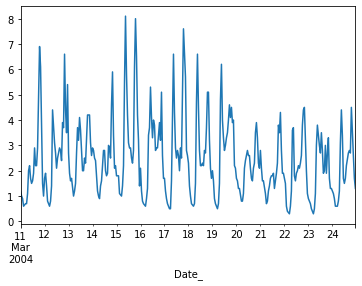

In [24]:
dt_ts.plot(kind = 'line')

In [25]:
dt_ts_reshape = pd.Series(dt_ts.values.reshape(-1,))
dt_ts_reshape

0      1.20
1      1.00
2      0.90
3      0.60
4      0.65
       ... 
331    4.50
332    3.50
333    2.60
334    1.70
335    1.30
Length: 336, dtype: float64

# Model to predict Carbon Monoxide

In [26]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [27]:
def data_sequences(ts_values):
    X_t, y_t = split_sequence(ts_values, n_steps)
    return X_t, y_t

In [28]:
# train --> 6 days
# val --> 1 day
# forecast --> 1 day

In [29]:
def train_test_sequences(X_t, y_t):
    X_t_train, y_t_train = X_t[:144-n_steps], y_t[:144-n_steps]
    X_t_val, y_t_val = X_t[144-n_steps:], y_t[144-n_steps:]
    return X_t_train, y_t_train, X_t_val, y_t_val

In [30]:
# define model
def TS_model(units_):
    
    model = Sequential()  
    model.add(LSTM(units=units_, input_shape=(n_steps, 1), activation = 'relu'))  
    model.add(Dropout(0.2))
    
#     model.add(LSTM(units=units_, activation = 'relu', return_sequences = True))  
#     model.add(Dropout(0.2))
    
#     model.add(LSTM(units=units_, activation = 'relu'))  
#     model.add(Dropout(0.2))
      
    model.add(Dense(units = 1))  
    
    model.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error')
    return model

In [31]:
def train_model(model, batch_size_, idx):
    earlyStopping = EarlyStopping(monitor='val_loss', patience=500, verbose=0, mode='min')
    mcp_save = ModelCheckpoint('co_model_%s.hdf5'%idx, save_best_only=True, 
                           monitor='val_loss', mode='min')
    reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, 
                                       verbose=1, min_delta=1e-4, mode='min')
    
    mod_trained = model.fit(X_t_train, y_t_train, epochs = 100, validation_data = (X_t_val, y_t_val), 
              batch_size = batch_size_, verbose = 2,
              callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
             )
    return mod_trained

In [34]:
# params
n_steps = 15
units = 50
batch_size = 16


# train model

start = datetime.datetime.now()

ts_model = TS_model(units)

mape_list = []
mod_list = []
pred_all = []


for day_idx in range(7):
    X_t, y_t = data_sequences(dt_ts_reshape[24*day_idx:24*(day_idx+7)].values)
    X_t_train, y_t_train, X_t_val, y_t_val = train_test_sequences(X_t, y_t)    
    
    mod_trained = train_model(ts_model, batch_size, day_idx)
    best_model = load_model('co_model_%s.hdf5'%day_idx)
    mod_list.append(best_model)
    
    X_t_test, y_t_test = data_sequences(dt_ts_reshape[24*(day_idx+7)-n_steps:24*(day_idx+8)].values)

    pred = best_model.predict(X_t_test)
    mape = mean_absolute_percentage_error(y_t_test, pred)
    
    pred_all.extend(pred)
    mape_list.append(mape)
            
    print('Forecasting for %s done, train and val set used is from %s until %s'%(dt_ts.index[24*(day_idx+7)].date(), dt_ts.index[24*(day_idx)].date(), dt_ts.index[24*(day_idx+6)].date()))
            
            
print("time needed for all process --> ", datetime.datetime.now()-start)

Epoch 1/100
9/9 - 1s - loss: 97.4284 - val_loss: 80.5059 - lr: 0.0010 - 851ms/epoch - 95ms/step
Epoch 2/100
9/9 - 0s - loss: 73.5538 - val_loss: 61.1680 - lr: 0.0010 - 42ms/epoch - 5ms/step
Epoch 3/100
9/9 - 0s - loss: 57.9887 - val_loss: 75.8343 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 4/100
9/9 - 0s - loss: 57.2120 - val_loss: 61.9076 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 5/100
9/9 - 0s - loss: 53.1249 - val_loss: 58.5428 - lr: 0.0010 - 43ms/epoch - 5ms/step
Epoch 6/100
9/9 - 0s - loss: 51.3118 - val_loss: 58.7405 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 7/100
9/9 - 0s - loss: 49.8356 - val_loss: 59.3257 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 8/100
9/9 - 0s - loss: 50.8171 - val_loss: 57.4119 - lr: 0.0010 - 43ms/epoch - 5ms/step
Epoch 9/100
9/9 - 0s - loss: 49.0973 - val_loss: 51.2616 - lr: 0.0010 - 48ms/epoch - 5ms/step
Epoch 10/100
9/9 - 0s - loss: 45.4644 - val_loss: 50.1164 - lr: 0.0010 - 48ms/epoch - 5ms/step
Epoch 11/100
9/9 - 0s - loss: 44.5459 - val_loss: 54.1055

Epoch 88/100
9/9 - 0s - loss: 26.5621 - val_loss: 37.6127 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 89/100
9/9 - 0s - loss: 28.1816 - val_loss: 31.8395 - lr: 0.0010 - 36ms/epoch - 4ms/step
Epoch 90/100
9/9 - 0s - loss: 25.7938 - val_loss: 36.5907 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 91/100
9/9 - 0s - loss: 26.6584 - val_loss: 33.5512 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 92/100
9/9 - 0s - loss: 24.2200 - val_loss: 28.2531 - lr: 0.0010 - 36ms/epoch - 4ms/step
Epoch 93/100
9/9 - 0s - loss: 25.2467 - val_loss: 26.3345 - lr: 0.0010 - 42ms/epoch - 5ms/step
Epoch 94/100
9/9 - 0s - loss: 31.2997 - val_loss: 25.0924 - lr: 0.0010 - 44ms/epoch - 5ms/step
Epoch 95/100
9/9 - 0s - loss: 26.0489 - val_loss: 41.8058 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 96/100
9/9 - 0s - loss: 27.8375 - val_loss: 32.9069 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 97/100
9/9 - 0s - loss: 26.8463 - val_loss: 32.9355 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 98/100
9/9 - 0s - loss: 22.6400 - val_loss: 

Epoch 74/100
9/9 - 0s - loss: 27.5354 - val_loss: 22.3824 - lr: 0.0010 - 32ms/epoch - 4ms/step
Epoch 75/100
9/9 - 0s - loss: 23.7639 - val_loss: 24.3464 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 76/100
9/9 - 0s - loss: 23.4598 - val_loss: 21.9663 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 77/100
9/9 - 0s - loss: 25.1125 - val_loss: 17.3003 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 78/100
9/9 - 0s - loss: 25.6508 - val_loss: 16.8605 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 79/100
9/9 - 0s - loss: 23.0420 - val_loss: 19.5083 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 80/100
9/9 - 0s - loss: 23.5286 - val_loss: 16.8700 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 81/100
9/9 - 0s - loss: 22.7959 - val_loss: 15.8053 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 82/100
9/9 - 0s - loss: 22.8359 - val_loss: 12.7405 - lr: 0.0010 - 42ms/epoch - 5ms/step
Epoch 83/100
9/9 - 0s - loss: 21.8549 - val_loss: 13.3211 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 84/100
9/9 - 0s - loss: 22.1441 - val_loss: 

Epoch 60/100
9/9 - 0s - loss: 19.6510 - val_loss: 19.8097 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 61/100
9/9 - 0s - loss: 22.3090 - val_loss: 19.1402 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 62/100
9/9 - 0s - loss: 21.0775 - val_loss: 19.7483 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 63/100
9/9 - 0s - loss: 19.0224 - val_loss: 17.3403 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 64/100
9/9 - 0s - loss: 19.6261 - val_loss: 20.1071 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 65/100
9/9 - 0s - loss: 22.6630 - val_loss: 19.7734 - lr: 0.0010 - 36ms/epoch - 4ms/step
Epoch 66/100
9/9 - 0s - loss: 20.7109 - val_loss: 18.3141 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 67/100
9/9 - 0s - loss: 19.8424 - val_loss: 19.9131 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 68/100
9/9 - 0s - loss: 21.0467 - val_loss: 19.6866 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 69/100
9/9 - 0s - loss: 20.0930 - val_loss: 18.5989 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 70/100
9/9 - 0s - loss: 21.4422 - val_loss: 

Epoch 46/100
9/9 - 0s - loss: 17.5290 - val_loss: 24.3223 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 47/100
9/9 - 0s - loss: 15.5053 - val_loss: 25.4774 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 48/100
9/9 - 0s - loss: 18.0115 - val_loss: 20.9505 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 49/100
9/9 - 0s - loss: 18.9729 - val_loss: 23.0777 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 50/100
9/9 - 0s - loss: 16.0729 - val_loss: 28.0505 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 51/100
9/9 - 0s - loss: 18.3529 - val_loss: 21.3070 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 52/100
9/9 - 0s - loss: 18.1595 - val_loss: 25.0165 - lr: 0.0010 - 38ms/epoch - 4ms/step
Epoch 53/100
9/9 - 0s - loss: 18.5269 - val_loss: 27.4186 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 54/100
9/9 - 0s - loss: 16.7105 - val_loss: 29.7141 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 55/100
9/9 - 0s - loss: 19.5856 - val_loss: 20.5680 - lr: 0.0010 - 36ms/epoch - 4ms/step
Epoch 56/100
9/9 - 0s - loss: 25.4451 - val_loss: 

Epoch 32/100
9/9 - 0s - loss: 15.8973 - val_loss: 32.8393 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 33/100
9/9 - 0s - loss: 21.0911 - val_loss: 44.2315 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 34/100
9/9 - 0s - loss: 19.4161 - val_loss: 19.5395 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 35/100
9/9 - 0s - loss: 17.1807 - val_loss: 20.7636 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 36/100
9/9 - 0s - loss: 17.7404 - val_loss: 22.1246 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 37/100
9/9 - 0s - loss: 16.1283 - val_loss: 25.1654 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 38/100
9/9 - 0s - loss: 16.6428 - val_loss: 29.7610 - lr: 0.0010 - 32ms/epoch - 4ms/step
Epoch 39/100
9/9 - 0s - loss: 18.2850 - val_loss: 18.5613 - lr: 0.0010 - 34ms/epoch - 4ms/step
Epoch 40/100
9/9 - 0s - loss: 16.8519 - val_loss: 18.0389 - lr: 0.0010 - 35ms/epoch - 4ms/step
Epoch 41/100
9/9 - 0s - loss: 16.6644 - val_loss: 23.3400 - lr: 0.0010 - 33ms/epoch - 4ms/step
Epoch 42/100
9/9 - 0s - loss: 15.9501 - val_loss: 

Epoch 7/100
9/9 - 0s - loss: 16.2560 - val_loss: 64.2033 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 8/100
9/9 - 0s - loss: 17.9062 - val_loss: 61.9755 - lr: 1.0000e-04 - 42ms/epoch - 5ms/step
Epoch 9/100
9/9 - 0s - loss: 16.5962 - val_loss: 61.7498 - lr: 1.0000e-04 - 43ms/epoch - 5ms/step
Epoch 10/100
9/9 - 0s - loss: 17.9007 - val_loss: 61.3763 - lr: 1.0000e-04 - 42ms/epoch - 5ms/step
Epoch 11/100
9/9 - 0s - loss: 17.2613 - val_loss: 59.8446 - lr: 1.0000e-04 - 43ms/epoch - 5ms/step
Epoch 12/100
9/9 - 0s - loss: 16.3078 - val_loss: 57.3219 - lr: 1.0000e-04 - 43ms/epoch - 5ms/step
Epoch 13/100
9/9 - 0s - loss: 17.0451 - val_loss: 57.3038 - lr: 1.0000e-04 - 42ms/epoch - 5ms/step
Epoch 14/100
9/9 - 0s - loss: 16.5083 - val_loss: 57.7598 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 15/100
9/9 - 0s - loss: 16.2007 - val_loss: 57.1618 - lr: 1.0000e-04 - 43ms/epoch - 5ms/step
Epoch 16/100
9/9 - 0s - loss: 16.3266 - val_loss: 57.5075 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 17/100


Epoch 90/100
9/9 - 0s - loss: 15.7531 - val_loss: 56.1798 - lr: 1.0000e-04 - 33ms/epoch - 4ms/step
Epoch 91/100
9/9 - 0s - loss: 15.6017 - val_loss: 54.5826 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 92/100
9/9 - 0s - loss: 14.4770 - val_loss: 52.5478 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 93/100
9/9 - 0s - loss: 15.5896 - val_loss: 51.8423 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 94/100
9/9 - 0s - loss: 15.8538 - val_loss: 53.6905 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 95/100
9/9 - 0s - loss: 15.6115 - val_loss: 52.8975 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 96/100
9/9 - 0s - loss: 16.4063 - val_loss: 50.7902 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 97/100
9/9 - 0s - loss: 16.3883 - val_loss: 48.5990 - lr: 1.0000e-04 - 33ms/epoch - 4ms/step
Epoch 98/100
9/9 - 0s - loss: 15.7020 - val_loss: 47.7091 - lr: 1.0000e-04 - 33ms/epoch - 4ms/step
Epoch 99/100
9/9 - 0s - loss: 16.4781 - val_loss: 48.5531 - lr: 1.0000e-04 - 36ms/epoch - 4ms/step
Epoch 100/

Epoch 65/100
9/9 - 0s - loss: 19.5925 - val_loss: 23.9005 - lr: 1.0000e-04 - 37ms/epoch - 4ms/step
Epoch 66/100
9/9 - 0s - loss: 18.5456 - val_loss: 23.6169 - lr: 1.0000e-04 - 35ms/epoch - 4ms/step
Epoch 67/100
9/9 - 0s - loss: 18.3473 - val_loss: 23.6097 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 68/100
9/9 - 0s - loss: 18.0803 - val_loss: 23.6521 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 69/100
9/9 - 0s - loss: 17.9860 - val_loss: 23.7464 - lr: 1.0000e-04 - 33ms/epoch - 4ms/step
Epoch 70/100
9/9 - 0s - loss: 18.8774 - val_loss: 23.7019 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 71/100
9/9 - 0s - loss: 17.3845 - val_loss: 23.3669 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 72/100
9/9 - 0s - loss: 18.0278 - val_loss: 23.3234 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 73/100
9/9 - 0s - loss: 18.8302 - val_loss: 23.1016 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 74/100
9/9 - 0s - loss: 18.2516 - val_loss: 23.0895 - lr: 1.0000e-04 - 34ms/epoch - 4ms/step
Epoch 75/1

In [52]:
mod_list[0].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [35]:
mape_list

[0.2594702123983865,
 0.19894683110297903,
 0.22051144878279838,
 0.17607665359377708,
 0.36944144706053456,
 0.28570796223223477,
 0.20017704823467075]

In [43]:
date_list = [str(dt_ts.index[24*(day_idx+7)].date()) for day_idx in range(7)]
date_list

['2004-03-18',
 '2004-03-19',
 '2004-03-20',
 '2004-03-21',
 '2004-03-22',
 '2004-03-23',
 '2004-03-24']

In [44]:
mape_all = statistics.mean(mape_list)
mape_list.append(mape_all)

date_list.append('Average')

In [45]:
error_df = pd.DataFrame(list(zip(date_list, mape_list)),
                       columns = ['Date', 'MAPE'])

error_df

,Date,MAPE
0,2004-03-18,0.259470
1,2004-03-19,0.198947
2,2004-03-20,0.220511
3,2004-03-21,0.176077
4,2004-03-22,0.369441
5,2004-03-23,0.285708
6,2004-03-24,0.200177
7,Average,0.244333


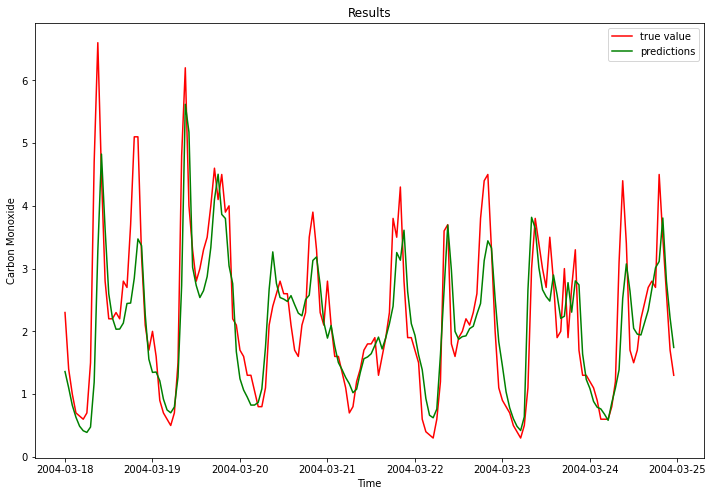

In [37]:
index = dt_ts.index

plt.figure(figsize=(12,8))
plt.plot(index[168:], dt_ts[168:].values, color = 'r', label = 'true value')
plt.plot(index[168:], pred_all, color = 'g', label = 'predictions')
plt.title('Results')
plt.xlabel('Time')
plt.ylabel('Carbon Monoxide')
plt.legend()
plt.show()

In [46]:
date_pred = [dt_ts.index[i] for i in range(168,336)]

In [47]:
pred_all_list = [pred_all[i][0] for i in range(len(pred_all))]

In [49]:
pred_dt = pd.DataFrame(list(zip(date_pred, pred_all_list)),
                      columns = ['Date', 'CO_predict'])
pred_dt.to_csv('co_pred.csv')

In [50]:
pred_dt.head()

,Date,CO_predict
0,2004-03-18 00:00:00,1.358941
1,2004-03-18 01:00:00,1.101553
2,2004-03-18 02:00:00,0.821480
3,2004-03-18 03:00:00,0.631121
4,2004-03-18 04:00:00,0.488651


In [38]:
# export csv : date-hour and predicted value
# print neat daily mape and average mape
# gcolab
# py file
# model explanation